# Advanced geospatial plotting 

### Importing Data and Modules

In [7]:
import pandas as pd
import os
from keplergl import KeplerGl
from pyproj import CRS
import numpy as np
from matplotlib import pyplot as plt

In [8]:
df = pd.read_csv('ny_city_modified_data.csv', index_col = 0)

C:\Users\gerar\AppData\Local\Temp\ipykernel_30656\3317881836.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ny_city_modified_data.csv', index_col = 0)


In [9]:
df.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station,start_station_id,end_station,end_station_id,start_lat,start_lng,end_lat,end_lng,user_type,date,avgTemp,bike_rides_daily,_merge,value,trip_duration
111985,2F9F292E7264D4D5,classic_bike,2022-06-19 18:08:52.457,2022-06-19 18:13:11.541,E 1 St & 1 Ave,5593.01,E 6 St & 2 Ave,5669.12,40.723356,-73.988650,40.727379,-73.988408,member,2022-06-19,17.3,1024,both,1,4.318067
39559,A8F06A8B8C641E31,classic_bike,2022-03-30 14:21:01.069,2022-03-30 14:26:35.285,W 36 St & 9 Ave,6569.07,W 31 St & 7 Ave,6331.01,40.754623,-73.995168,40.749156,-73.991600,member,2022-03-30,2.6,631,both,1,5.570267
206239,C8AC37CF346C2AE1,classic_bike,2022-09-11 16:24:32.621,2022-09-11 16:34:07.306,Central Park West & W 72 St,7141.07,W 84 St & Columbus Ave,7382.04,40.775794,-73.976206,40.785000,-73.972834,member,2022-09-11,23.2,674,both,1,9.578083
224925,0B00CF07A37C3F16,classic_bike,2022-09-27 15:54:17.535,2022-09-27 16:53:21.407,W 87 St & Amsterdam Ave,7458.03,Broadway & E 21 St,6098.10,40.788390,-73.974700,40.739888,-73.989586,casual,2022-09-27,19.7,1160,both,1,59.064533
28035,D4435F3641B3FC97,classic_bike,2022-03-11 12:09:14.065,2022-03-11 12:14:28.462,Allen St & Rivington St,5414.06,Division St & Bowery,5270.08,40.720196,-73.989978,40.714193,-73.996732,member,2022-03-11,7.2,719,both,1,5.239950


##### Remove obsolete columns

In [11]:
df.drop(columns = ['_merge', 'value'], inplace = True)

In [12]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station',
       'start_station_id', 'end_station', 'end_station_id', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'user_type', 'date', 'avgTemp',
       'bike_rides_daily', 'trip_duration'],
      dtype='object')

## Data preprocessing

##### Create a dataframe with only the necessary columns

In [15]:
df_coordinates = df[['start_station', 'end_station', 'start_lat',
       'start_lng', 'end_lat', 'end_lng']] 
df_coordinates.head()

,start_station,end_station,start_lat,start_lng,end_lat,end_lng
0,John St & William St,Canal St & Rutgers St,40.708621,-74.007222,40.714275,-73.989900
1,Adelphi St & Myrtle Ave,Dean St & Franklin Ave,40.693083,-73.971789,40.677592,-73.955637
2,W 15 St & 6 Ave,E 7 St & Avenue A,40.738046,-73.996430,40.726218,-73.983799
3,Carmine St & 6 Ave,Washington Pl & 6 Ave,40.730386,-74.002150,40.732241,-74.000264
4,Greenwich St & Perry St,Greenwich St & W Houston St,40.734980,-74.006970,40.728846,-74.008591


In [16]:
# drop duplicates on df_coordinates based off start_station and end_station. Only one combination possible. Removes duplicate coordinates.  
df_coordinates = df_coordinates.drop_duplicates(subset = ['start_station', 'end_station'], keep='first', inplace=False, ignore_index=True)
df_coordinates.sample(10)

,start_station,end_station,start_lat,start_lng,end_lat,end_lng
87612,E 2 St & Avenue C,6 Ave & W 34 St,40.720874,-73.980858,40.749640,-73.988050
122951,W 13 St & 7 Ave,Central Park S & 6 Ave,40.737815,-73.999947,40.765909,-73.976342
124636,Rutgers St & Henry St,E 20 St & 2 Ave,40.713213,-73.990058,40.735877,-73.982050
74810,Marcy Ave & Lafayette Ave,Clinton Ave & Myrtle Ave,40.690081,-73.947915,40.693261,-73.968896
17200,W 42 St & 6 Ave,Madison Ave & E 82 St,40.754920,-73.984550,40.778131,-73.960694
11403,E 14 St & Avenue B,Cooper Square & Astor Pl,40.729387,-73.977724,40.729515,-73.990753
107953,16th St & 4th Ave,Washington Pl & Broadway,40.666197,-73.992466,40.729039,-73.994046
29079,FDR Drive & E 35 St,E 33 St & 1 Ave,40.744219,-73.971212,40.743227,-73.974498
282,Grand St & Havemeyer St,Morgan Ave & Lombardy St,40.712868,-73.956981,40.722260,-73.938890
29823,Ditmars Blvd & 76 St,Amsterdam Ave & W 82 St,40.768442,-73.893531,40.785247,-73.976673


In [17]:
# Create a value column and group by start and end station. This value can be anything, a number or string.
# It is simply a placeholder

df['value'] = 1
df_group = df.groupby(['start_station', 'end_station'])['value'].count().reset_index()


In [18]:
df_group

,start_station,end_station,value
0,1 Ave & E 110 St,1 Ave & E 110 St,8
1,1 Ave & E 110 St,1 Ave & E 62 St,1
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2
...,...,...,...
149391,Yankee Ferry Terminal,Broad St & Bridge St,1
149392,Yankee Ferry Terminal,Court St & Nelson St,1
149393,Yankee Ferry Terminal,Picnic Point,34
149394,Yankee Ferry Terminal,Soissons Landing,49


In [19]:
# Rename value column for a more intuitive name

df_group.rename(columns = {'value' : 'station_pair_trip_count'}, inplace = True)
df_group

,start_station,end_station,station_pair_trip_count
0,1 Ave & E 110 St,1 Ave & E 110 St,8
1,1 Ave & E 110 St,1 Ave & E 62 St,1
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2
...,...,...,...
149391,Yankee Ferry Terminal,Broad St & Bridge St,1
149392,Yankee Ferry Terminal,Court St & Nelson St,1
149393,Yankee Ferry Terminal,Picnic Point,34
149394,Yankee Ferry Terminal,Soissons Landing,49


In [20]:
df_merged = pd.merge(df_coordinates, df_group, on = ['start_station', 'end_station'], how='inner', indicator = True)
df_merged.sample(5)

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count,_merge
79748,McKibbin St & Manhattan Ave,Graham Ave & Conselyea St,40.705109,-73.944073,40.715143,-73.944507,2,both
8561,W 67 St & Broadway,Central Park West & W 72 St,40.774925,-73.982666,40.775794,-73.976206,4,both
40799,Jay St & Tech Pl,Congress St & Hicks St,40.695065,-73.987167,40.689395,-73.999513,1,both
2239,Amsterdam Ave & W 73 St,W 52 St & 11 Ave,40.779668,-73.980930,40.767272,-73.993929,2,both
137171,9 Ave & W 18 St,LaGuardia Pl & W 3 St,40.743198,-74.003547,40.729170,-73.998102,1,both


In [21]:
# Sort dataframe to get only the top 150 trips based off the station_pair_trip_count (reset to new index) 
df_top_150 = df_merged.nlargest(n = 150, columns = 'station_pair_trip_count').reset_index(drop = True)
df_top_150

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count,_merge
0,Central Park S & 6 Ave,Central Park S & 6 Ave,40.765909,-73.976342,40.765909,-73.976342,110,both
1,7 Ave & Central Park South,7 Ave & Central Park South,40.766741,-73.979069,40.766741,-73.979069,73,both
2,Roosevelt Island Tramway,Roosevelt Island Tramway,40.757284,-73.953600,40.757284,-73.953600,73,both
3,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,40.764397,-73.973715,40.764397,-73.973715,71,both
4,W 21 St & 6 Ave,9 Ave & W 22 St,40.741740,-73.994156,40.745497,-74.001971,64,both
...,...,...,...,...,...,...,...,...
145,West St & Liberty St,West St & Chambers St,40.711444,-74.014847,40.717548,-74.013221,26,both
146,Vernon Blvd & 50 Ave,46 Ave & 5 St,40.742327,-73.954117,40.747310,-73.954510,26,both
147,10 Ave & W 14 St,West St & Liberty St,40.741982,-74.008316,40.711444,-74.014847,26,both
148,Central Park S & 6 Ave,5 Ave & E 72 St,40.765909,-73.976342,40.772828,-73.966853,26,both


In [22]:
# Checking shape of dataframe
print(df_top_150['station_pair_trip_count'].sum())
print(df.shape)

5353
(297971, 18)


In [23]:
# Perform basic EDA of df_group
df_top_150['station_pair_trip_count'].describe()

count    150.000000
mean      35.686667
std       12.333257
min       26.000000
25%       27.000000
50%       30.000000
75%       40.000000
max      110.000000
Name: station_pair_trip_count, dtype: float64

### Exploratory Analysis Charts

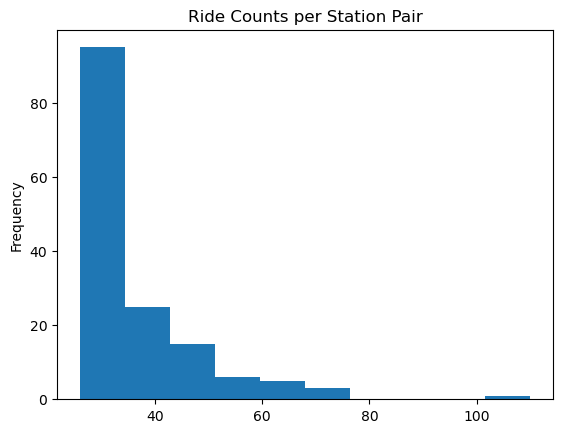

In [25]:
hist_plot_ride_counts = df_top_150['station_pair_trip_count'].plot(kind = 'hist', bins = 10, title = 'Ride Counts per Station Pair')

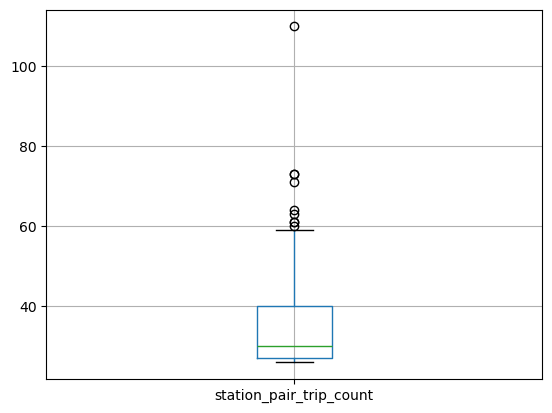

In [26]:
box_plot_ride_counts = df_top_150.boxplot(column = 'station_pair_trip_count') 

In [27]:
# remove obsolete columns

df_top_150.drop(columns = '_merge', inplace = True)

In [28]:
df_top_150.sample(5)

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count
140,E 2 St & Avenue B,E 1 St & 1 Ave,40.722174,-73.983688,40.723356,-73.988650,26
135,W 21 St & 6 Ave,W 22 St & 8 Ave,40.741740,-73.994156,40.744751,-73.999154,26
118,W 20 St & 10 Ave,W 20 St & 8 Ave,40.745686,-74.005141,40.743453,-74.000040,27
27,1 Ave & E 68 St,1 Ave & E 78 St,40.765005,-73.958185,40.771404,-73.953517,44
29,Central Park North & Adam Clayton Powell Blvd,Central Park North & Adam Clayton Powell Blvd,40.799484,-73.955613,40.799484,-73.955613,44


In [29]:
# Use garbage collector to improve code performance
import gc 
gc.collect()

20

## Plot the map

In [31]:
# is this really neccesary? exporting this dataset. Can we discuss this during the call? 
# df_final.to_csv('df_final_locations_for_map.csv')

In [32]:
df_top_150.to_csv('top_150_trips.csv', index = False)

In [33]:
df_top_150.head()

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count
0,Central Park S & 6 Ave,Central Park S & 6 Ave,40.765909,-73.976342,40.765909,-73.976342,110
1,7 Ave & Central Park South,7 Ave & Central Park South,40.766741,-73.979069,40.766741,-73.979069,73
2,Roosevelt Island Tramway,Roosevelt Island Tramway,40.757284,-73.953600,40.757284,-73.953600,73
3,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,40.764397,-73.973715,40.764397,-73.973715,71
4,W 21 St & 6 Ave,9 Ave & W 22 St,40.741740,-73.994156,40.745497,-74.001971,64


In [38]:
df_top_10 = df_top_150.nlargest(10, 'station_pair_trip_count')
df_top_10
#df_top_10.to_csv('top_10_trips.csv', index = False)

,start_station,end_station,start_lat,start_lng,end_lat,end_lng,station_pair_trip_count
0,Central Park S & 6 Ave,Central Park S & 6 Ave,40.765909,-73.976342,40.765909,-73.976342,110
1,7 Ave & Central Park South,7 Ave & Central Park South,40.766741,-73.979069,40.766741,-73.979069,73
2,Roosevelt Island Tramway,Roosevelt Island Tramway,40.757284,-73.953600,40.757284,-73.953600,73
3,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,40.764397,-73.973715,40.764397,-73.973715,71
4,W 21 St & 6 Ave,9 Ave & W 22 St,40.741740,-73.994156,40.745497,-74.001971,64
5,Yankee Ferry Terminal,Yankee Ferry Terminal,40.687066,-74.016756,40.687066,-74.016756,63
6,Broadway & W 58 St,Broadway & W 58 St,40.766953,-73.981693,40.766953,-73.981693,61
7,Soissons Landing,Soissons Landing,40.692317,-74.014866,40.692317,-74.014866,61
8,North Moore St & Greenwich St,Vesey St & Church St,40.720195,-74.010301,40.712220,-74.010472,60
9,5 Ave & E 72 St,5 Ave & E 72 St,40.772828,-73.966853,40.772828,-73.966853,59
